# IDAO bootcamp deep leanning

### Plans for this notebook:

1. Quick introduction in deep learning
2. **Pytorch** basics
3. Some details about learning pipeline
4. Build and apply simple fully connected nural network
5. Introduction to conv nets
6. Build and apply simple convolutional nural network
7. Discuss some other applications of DL



##### This notebook is strongly based on materials from: https://github.com/hse-ds/iad-deep-learning

# 1. Quick introduction in deep learning [mini-presentation](https://docs.google.com/presentation/d/1cc9n11O6I_18bunhgw8qfuJ7kp2ITD9hfIZsp_8lpJA/edit?usp=sharing)

# 2. Pytorch high level basics

#### 0. Set up enviroment if needed

In [ ]:
#!pip install pytorch
#!pip install numpy
#!pip install sklearn
#!pip install tqdm
#!pip install matplotlib

#### 1. Remembering numpy

In [3]:
import numpy as np

In [ ]:
# random matrix
a = np.random.rand(5, 3)
a

In [ ]:
print(f"Shape: {a.shape}")

In [ ]:
print(f"Add 5:\n{a + 5}")

In [ ]:
print(f"Matrix product X X^T:\n{a @ a.T}")

In [ ]:
print(f"Column mean:\n{a.mean(axis=-1)}")

In [ ]:
print(f"Change shape: {a.reshape(3, 5).shape}")

In [ ]:
## Some task here

#### 2. Lets do the same with pytorch

In [4]:
import torch
import torch.nn.functional as F
print(torch.__version__)

1.10.0+cu102


In [ ]:
x = torch.rand(5, 3)
x

In [ ]:
print(f"Shape: {x.shape}")

In [ ]:
print(f"Add 5:\n{x + 5}")

In [ ]:
# torch.mm, torch.matmul, torch.bmm, @
print(f"X X^T  (1):\n{torch.matmul(x, x.transpose(1, 0))}\n")
print(f"X X^T  (2):\n{x.mm(x.t())}")

In [ ]:
print(f"Column mean:\n{x.mean(dim=-1)}")

In [ ]:
print(f"Change shape:\n{x.reshape([3, 5]).shape}\n")

Some examples how operations changes:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype("int64") -> x.type(torch.LongTensor)`

More such examples you can find [here](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users)


In [ ]:
# Some task on pytorch here

#### 2. Basics of pytorch gradients

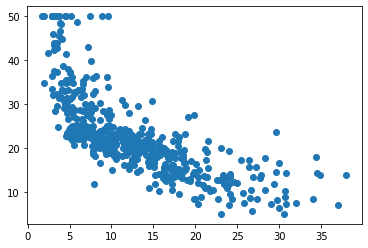

In [8]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target);

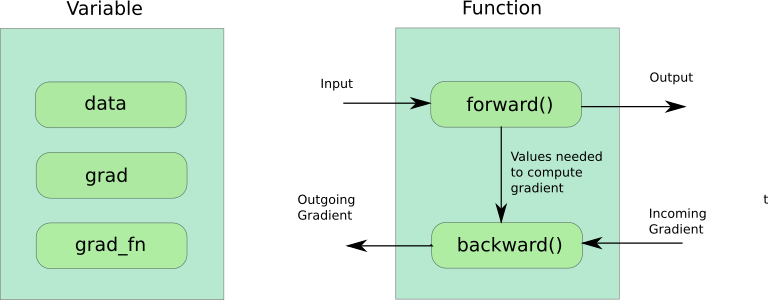

In [ ]:
# Lets create tensors with "requires_grad=True", which means that we want to calculate gradietnts for this tensor
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / boston.data[:, -1].max(), dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

assert w.grad is None
assert b.grad is None

In [ ]:
y_pred = w * x + b                    # make some operations
loss = torch.mean((y_pred - y) ** 2)  # make some operations
loss.backward()                       # calculate gradients with ".backward()"

# No we can see gradients
assert w.grad is not None
assert b.grad is not None

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

In [ ]:
from IPython.display import clear_output

for i in range(300):
    y_pred = w * x + b

    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    # make a step
    w.data -=  0.05 * w.grad
    b.data -=  0.05 * b.grad

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # рисуем картинки
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(x.data.numpy(), y.data.numpy(), label="data")
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color="orange", linewidth=5, label="predictions")
        plt.xlabel("LSTAT", fontsize=14)
        plt.ylabel("MEDV (target)", fontsize=14)
        plt.title("Boston modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.1:
            print("Done!")
            break


### 4. Some details about learning pipeline

Before build your neural network, you need to think about how to train it. Firstly, you need to implement batching of your dataset

In order in this framework to be able to iterate over the data you need to create your own class inherited from `torch.utils.data.Dataset`.


You **need to implement** who methods: 

* `__len__` -- returns information about how many objects we have in the dataset
* `__getitem__` -- returns the sample and the target to it


Now let's write one ourselves, generate random data as a dataset.

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {"sample": torch.tensor(x[idx, :], dtype=torch.float), "target": y[idx]}

In [ ]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [ ]:
our_dataset = RandomDataset(x, y)

In [ ]:
our_dataset.__getitem__(1)

In order to get batches from the data, pytorch uses such an entity as a dataloader, which accepts a class inherited from `torch.utils.data.Dataset` as input. Let's look at an example now:

In [ ]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

In [ ]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

### 5. Build and apply simple fully connected nural network

#### How to make a neural network


In order to create neural networks in high-level pytorch, the `nn` module is used. The neural network must be inherited from the `nn.Module` class. An example of how it might look

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

As we can see in this example, this class **must have a** method `forward`, which defines the direct passage of the neural network. Also from the class above you can see that the `nn` module contains the implementation of most of the layers, and the` nn.functional` module contains activation functions.

There is one more way to create a neural network and let's analyze it in practice:

In [13]:
from torch import nn

model = nn.Sequential()                   # create an empty model to which we will add layers
model.add_module("l1", nn.Linear(5, 10))  # added a layer with 5 neurons at the input and 3 at the output
model.add_module("l2", nn.ReLU())         # added activation function
model.add_module("l3", nn.Linear(10, 1))  # added a layer with 3 neurons at the input and 5 at the output

# other way to do the same
another_model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [ ]:
y_pred = model(batch['sample']) # making predictions

#### How to write a training loop and track metrics
 
Let's now collect data loading, create a model and train on the MNIST dataset that has already been created for us

In [ ]:
import torchvision

# we use a ready-made class from torch to load data for training
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# since this is already a class inherited from Tdataset, it can be immediately wrapped in a dataloader
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

In [ ]:
# let's look at what we are working with
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Flatten(),             # turning a 28x28 image into a 784 vector
    nn.Linear(28 * 28, 128),  # a linear layer that converts a vector of size 784 to a vector of size 128
    nn.ReLU(),                # non-linearity
    nn.Linear(128, 10),       # a linear layer that converts a vector of size 128 to a vector of size 10
)

# creating an optimizer that will update the weights of the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

The weights of the models are stored as matrices and look like this:

In [ ]:
[x for x in model.named_parameters()] 

In [ ]:
from tqdm.notebook import tqdm

# in total we will have 5 epochs (5 times in a row we will go through all the matches from the train)
for epoch in range(1):
    for x_train, y_train in tqdm(train_dataloader):    # we take the batch from the train loader
        y_pred = model(x_train)                        # making predictions
        loss = F.cross_entropy(y_pred, y_train)        # calculate loss
        loss.backward()                                # calculate gradients
        optimizer.step()                               # updete parametrs
        optimizer.zero_grad()                          # drop gradients
    
    if epoch % 2 == 0:
        val_loss = []                                  # loss storing list
        val_accuracy = []
        with torch.no_grad():                          # no need grads when testing
            for x_val, y_val in tqdm(val_dataloader):  # we take the batch from the val loader
                y_pred = model(x_val)                  # making predictions
                loss = F.cross_entropy(y_pred, y_val)  # calculate loss
                val_loss.append(loss.numpy())          # store
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        
        # print metrics
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

### 5. Introduction to conv nets [mini-presentation (continued)](https://docs.google.com/presentation/d/1cc9n11O6I_18bunhgw8qfuJ7kp2ITD9hfIZsp_8lpJA/edit?usp=sharing)

### 6. Build and apply simple convolutional nural network

In [10]:
def train_and_test_model(model, optimizer, epoches=5):
    # just copy and past code above
    for epoch in range(epoches):
        for x_train, y_train in tqdm(train_dataloader):    # we take the batch from the train loader
            y_pred = model(x_train)                        # making predictions
            loss = F.cross_entropy(y_pred, y_train)        # calculate loss
            loss.backward()                                # calculate gradients
            optimizer.step()                               # updete parametrs
            optimizer.zero_grad()                          # drop gradients

        if epoch % 2 == 0:
            val_loss = []                                  # loss storing list
            val_accuracy = []
            with torch.no_grad():                          # no need grads when testing
                for x_val, y_val in tqdm(val_dataloader):  # we take the batch from the val loader
                    y_pred = model(x_val)                  # making predictions
                    loss = F.cross_entropy(y_pred, y_val)  # calculate loss
                    val_loss.append(loss.numpy())          # store
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            # print metrics
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")
    

In [6]:
import torchvision

# we use a ready-made class from torch to load data for training
mnist_train = torchvision.datasets.CIFAR10(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
) 
mnist_val = torchvision.datasets.CIFAR10(
    "./mnist/",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# since this is already a class inherited from Tdataset, it can be immediately wrapped in a dataloader
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


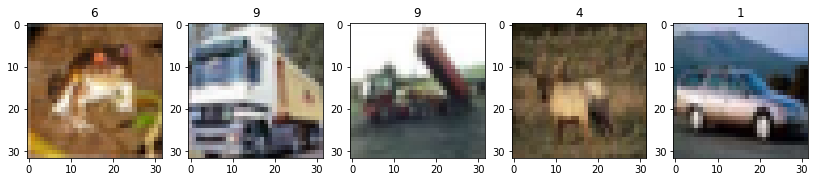

In [9]:
# let's look at what we are working with
plt.figure(figsize=(14, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(mnist_train[i][0].numpy(), [1,2,0]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [19]:
model = nn.Sequential(
    nn.Flatten(),                 # turning a 28x28 image into a 784 vector
    nn.Linear(3072, 128),  # a linear layer that converts a vector of size 784 to a vector of size 128
    nn.ReLU(),                    # non-linearity
    nn.Linear(128, 10),           # a linear layer that converts a vector of size 128 to a vector of size 10
)

# creating an optimizer that will update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_and_test_model(model, optimizer)

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 1.9295648336410522, accuracy: 0.2635


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 1.869468331336975, accuracy: 0.3009


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 1.850768804550171, accuracy: 0.3098


In [20]:
model = nn.Sequential(            
    nn.Conv2d(3, 128, 3),    # apply convolution with 128 filters size of 3
    nn.ReLU(),               # non-linearity
    nn.MaxPool2d(3),         # apply max pooling to image size reduction
    
    nn.Conv2d(128, 128, 3),  #
    nn.ReLU(),               # doing exactly the same 
    nn.MaxPool2d(3),         #
    
    nn.Flatten(),             # converting into a 512 vector
    nn.Linear(512, 10),       # a linear layer that converts a vector of size 512 to a vector of size 10
)

# creating an optimizer that will update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_and_test_model(model, optimizer)

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 1.389163851737976, accuracy: 0.5011


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 1.1750710010528564, accuracy: 0.5832


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 1.1005513668060303, accuracy: 0.6186


In [22]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(n_estimators=1000, verbose=True, task_type="GPU")
model.fit(mnist_train.data.reshape((-1, 3*32*32)), mnist_train.targets)
test_pred = model.predict_proba(mnist_val.data.reshape((-1, 3*32*32))).argmax(-1)
print(np.mean(test_pred == np.array(mnist_val.targets)))

Learning rate set to 0.057734
0:	learn: 2.2710519	total: 152ms	remaining: 7m 35s
1:	learn: 2.2431884	total: 290ms	remaining: 7m 14s
2:	learn: 2.2175831	total: 423ms	remaining: 7m 2s
3:	learn: 2.1944233	total: 554ms	remaining: 6m 55s
4:	learn: 2.1734311	total: 684ms	remaining: 6m 49s
5:	learn: 2.1545056	total: 814ms	remaining: 6m 46s
6:	learn: 2.1363822	total: 943ms	remaining: 6m 43s
7:	learn: 2.1193650	total: 1.07s	remaining: 6m 41s
8:	learn: 2.1036716	total: 1.2s	remaining: 6m 39s
9:	learn: 2.0887725	total: 1.33s	remaining: 6m 38s
10:	learn: 2.0750569	total: 1.46s	remaining: 6m 37s
11:	learn: 2.0616691	total: 1.59s	remaining: 6m 36s
12:	learn: 2.0498786	total: 1.72s	remaining: 6m 35s
13:	learn: 2.0373509	total: 1.85s	remaining: 6m 35s
14:	learn: 2.0253611	total: 1.98s	remaining: 6m 34s
15:	learn: 2.0145386	total: 2.11s	remaining: 6m 34s
16:	learn: 2.0043619	total: 2.24s	remaining: 6m 33s
17:	learn: 1.9947303	total: 2.37s	remaining: 6m 33s
18:	learn: 1.9844303	total: 2.5s	remaining: 6m

158:	learn: 1.5220586	total: 20.6s	remaining: 6m 8s
159:	learn: 1.5206431	total: 20.7s	remaining: 6m 8s
160:	learn: 1.5191156	total: 20.9s	remaining: 6m 8s
161:	learn: 1.5174541	total: 21s	remaining: 6m 8s
162:	learn: 1.5156037	total: 21.1s	remaining: 6m 7s
163:	learn: 1.5139016	total: 21.3s	remaining: 6m 7s
164:	learn: 1.5122848	total: 21.4s	remaining: 6m 7s
165:	learn: 1.5106078	total: 21.5s	remaining: 6m 7s
166:	learn: 1.5090419	total: 21.7s	remaining: 6m 7s
167:	learn: 1.5076572	total: 21.8s	remaining: 6m 7s
168:	learn: 1.5057836	total: 21.9s	remaining: 6m 7s
169:	learn: 1.5040606	total: 22s	remaining: 6m 6s
170:	learn: 1.5021706	total: 22.2s	remaining: 6m 6s
171:	learn: 1.5002287	total: 22.3s	remaining: 6m 6s
172:	learn: 1.4982830	total: 22.4s	remaining: 6m 6s
173:	learn: 1.4971800	total: 22.6s	remaining: 6m 6s
174:	learn: 1.4958288	total: 22.7s	remaining: 6m 6s
175:	learn: 1.4942444	total: 22.8s	remaining: 6m 6s
176:	learn: 1.4925509	total: 22.9s	remaining: 6m 5s
177:	learn: 1.49

316:	learn: 1.3300625	total: 40.9s	remaining: 5m 46s
317:	learn: 1.3288755	total: 41.1s	remaining: 5m 46s
318:	learn: 1.3280959	total: 41.2s	remaining: 5m 46s
319:	learn: 1.3273134	total: 41.3s	remaining: 5m 46s
320:	learn: 1.3263548	total: 41.5s	remaining: 5m 46s
321:	learn: 1.3254503	total: 41.6s	remaining: 5m 45s
322:	learn: 1.3246550	total: 41.7s	remaining: 5m 45s
323:	learn: 1.3241119	total: 41.8s	remaining: 5m 45s
324:	learn: 1.3232508	total: 42s	remaining: 5m 45s
325:	learn: 1.3221095	total: 42.1s	remaining: 5m 45s
326:	learn: 1.3209198	total: 42.2s	remaining: 5m 45s
327:	learn: 1.3202475	total: 42.4s	remaining: 5m 45s
328:	learn: 1.3195266	total: 42.5s	remaining: 5m 44s
329:	learn: 1.3185272	total: 42.6s	remaining: 5m 44s
330:	learn: 1.3176862	total: 42.7s	remaining: 5m 44s
331:	learn: 1.3164955	total: 42.9s	remaining: 5m 44s
332:	learn: 1.3157234	total: 43s	remaining: 5m 44s
333:	learn: 1.3145958	total: 43.1s	remaining: 5m 44s
334:	learn: 1.3138463	total: 43.3s	remaining: 5m 4

472:	learn: 1.2050104	total: 1m	remaining: 5m 25s
473:	learn: 1.2040495	total: 1m 1s	remaining: 5m 25s
474:	learn: 1.2031361	total: 1m 1s	remaining: 5m 25s
475:	learn: 1.2024603	total: 1m 1s	remaining: 5m 25s
476:	learn: 1.2019153	total: 1m 1s	remaining: 5m 25s
477:	learn: 1.2012298	total: 1m 1s	remaining: 5m 24s
478:	learn: 1.2004466	total: 1m 1s	remaining: 5m 24s
479:	learn: 1.1999159	total: 1m 1s	remaining: 5m 24s
480:	learn: 1.1990225	total: 1m 1s	remaining: 5m 24s
481:	learn: 1.1979869	total: 1m 2s	remaining: 5m 24s
482:	learn: 1.1976267	total: 1m 2s	remaining: 5m 24s
483:	learn: 1.1967667	total: 1m 2s	remaining: 5m 24s
484:	learn: 1.1960981	total: 1m 2s	remaining: 5m 23s
485:	learn: 1.1953002	total: 1m 2s	remaining: 5m 23s
486:	learn: 1.1947936	total: 1m 2s	remaining: 5m 23s
487:	learn: 1.1938744	total: 1m 2s	remaining: 5m 23s
488:	learn: 1.1932619	total: 1m 2s	remaining: 5m 23s
489:	learn: 1.1927504	total: 1m 3s	remaining: 5m 23s
490:	learn: 1.1918903	total: 1m 3s	remaining: 5m 

626:	learn: 1.1103302	total: 1m 20s	remaining: 5m 4s
627:	learn: 1.1096781	total: 1m 20s	remaining: 5m 4s
628:	learn: 1.1090019	total: 1m 20s	remaining: 5m 4s
629:	learn: 1.1083087	total: 1m 20s	remaining: 5m 4s
630:	learn: 1.1077164	total: 1m 20s	remaining: 5m 4s
631:	learn: 1.1071552	total: 1m 21s	remaining: 5m 3s
632:	learn: 1.1063113	total: 1m 21s	remaining: 5m 3s
633:	learn: 1.1060086	total: 1m 21s	remaining: 5m 3s
634:	learn: 1.1054766	total: 1m 21s	remaining: 5m 3s
635:	learn: 1.1048144	total: 1m 21s	remaining: 5m 3s
636:	learn: 1.1044213	total: 1m 21s	remaining: 5m 3s
637:	learn: 1.1036658	total: 1m 21s	remaining: 5m 3s
638:	learn: 1.1029974	total: 1m 22s	remaining: 5m 3s
639:	learn: 1.1023320	total: 1m 22s	remaining: 5m 2s
640:	learn: 1.1016958	total: 1m 22s	remaining: 5m 2s
641:	learn: 1.1009737	total: 1m 22s	remaining: 5m 2s
642:	learn: 1.1003882	total: 1m 22s	remaining: 5m 2s
643:	learn: 1.0998433	total: 1m 22s	remaining: 5m 2s
644:	learn: 1.0993781	total: 1m 22s	remaining:

780:	learn: 1.0307909	total: 1m 40s	remaining: 4m 44s
781:	learn: 1.0304469	total: 1m 40s	remaining: 4m 44s
782:	learn: 1.0299741	total: 1m 40s	remaining: 4m 43s
783:	learn: 1.0293679	total: 1m 40s	remaining: 4m 43s
784:	learn: 1.0286431	total: 1m 40s	remaining: 4m 43s
785:	learn: 1.0282587	total: 1m 40s	remaining: 4m 43s
786:	learn: 1.0278975	total: 1m 40s	remaining: 4m 43s
787:	learn: 1.0274269	total: 1m 40s	remaining: 4m 43s
788:	learn: 1.0271859	total: 1m 41s	remaining: 4m 43s
789:	learn: 1.0267739	total: 1m 41s	remaining: 4m 42s
790:	learn: 1.0263828	total: 1m 41s	remaining: 4m 42s
791:	learn: 1.0257397	total: 1m 41s	remaining: 4m 42s
792:	learn: 1.0253736	total: 1m 41s	remaining: 4m 42s
793:	learn: 1.0250973	total: 1m 41s	remaining: 4m 42s
794:	learn: 1.0245373	total: 1m 41s	remaining: 4m 42s
795:	learn: 1.0237990	total: 1m 41s	remaining: 4m 42s
796:	learn: 1.0234622	total: 1m 42s	remaining: 4m 42s
797:	learn: 1.0229943	total: 1m 42s	remaining: 4m 41s
798:	learn: 1.0224467	total:

932:	learn: 0.9619052	total: 1m 59s	remaining: 4m 24s
933:	learn: 0.9617169	total: 1m 59s	remaining: 4m 24s
934:	learn: 0.9614394	total: 1m 59s	remaining: 4m 24s
935:	learn: 0.9609398	total: 1m 59s	remaining: 4m 24s
936:	learn: 0.9603641	total: 1m 59s	remaining: 4m 23s
937:	learn: 0.9597795	total: 1m 59s	remaining: 4m 23s
938:	learn: 0.9591352	total: 2m	remaining: 4m 23s
939:	learn: 0.9587551	total: 2m	remaining: 4m 23s
940:	learn: 0.9582695	total: 2m	remaining: 4m 23s
941:	learn: 0.9580088	total: 2m	remaining: 4m 23s
942:	learn: 0.9575337	total: 2m	remaining: 4m 23s
943:	learn: 0.9571328	total: 2m	remaining: 4m 23s
944:	learn: 0.9568682	total: 2m	remaining: 4m 22s
945:	learn: 0.9562767	total: 2m 1s	remaining: 4m 22s
946:	learn: 0.9558591	total: 2m 1s	remaining: 4m 22s
947:	learn: 0.9552222	total: 2m 1s	remaining: 4m 22s
948:	learn: 0.9548997	total: 2m 1s	remaining: 4m 22s
949:	learn: 0.9546216	total: 2m 1s	remaining: 4m 22s
950:	learn: 0.9540613	total: 2m 1s	remaining: 4m 22s
951:	lea

1086:	learn: 0.8980464	total: 2m 18s	remaining: 4m 4s
1087:	learn: 0.8976455	total: 2m 19s	remaining: 4m 4s
1088:	learn: 0.8973216	total: 2m 19s	remaining: 4m 4s
1089:	learn: 0.8968272	total: 2m 19s	remaining: 4m 4s
1090:	learn: 0.8963356	total: 2m 19s	remaining: 4m 4s
1091:	learn: 0.8958768	total: 2m 19s	remaining: 4m 3s
1092:	learn: 0.8954212	total: 2m 19s	remaining: 4m 3s
1093:	learn: 0.8948858	total: 2m 19s	remaining: 4m 3s
1094:	learn: 0.8946057	total: 2m 19s	remaining: 4m 3s
1095:	learn: 0.8944078	total: 2m 20s	remaining: 4m 3s
1096:	learn: 0.8940602	total: 2m 20s	remaining: 4m 3s
1097:	learn: 0.8934905	total: 2m 20s	remaining: 4m 3s
1098:	learn: 0.8930191	total: 2m 20s	remaining: 4m 3s
1099:	learn: 0.8928370	total: 2m 20s	remaining: 4m 2s
1100:	learn: 0.8924183	total: 2m 20s	remaining: 4m 2s
1101:	learn: 0.8921134	total: 2m 20s	remaining: 4m 2s
1102:	learn: 0.8915892	total: 2m 21s	remaining: 4m 2s
1103:	learn: 0.8911388	total: 2m 21s	remaining: 4m 2s
1104:	learn: 0.8907856	total

1238:	learn: 0.8416461	total: 2m 38s	remaining: 3m 44s
1239:	learn: 0.8410984	total: 2m 38s	remaining: 3m 44s
1240:	learn: 0.8407578	total: 2m 38s	remaining: 3m 44s
1241:	learn: 0.8404019	total: 2m 38s	remaining: 3m 44s
1242:	learn: 0.8400622	total: 2m 38s	remaining: 3m 44s
1243:	learn: 0.8396508	total: 2m 38s	remaining: 3m 44s
1244:	learn: 0.8391999	total: 2m 38s	remaining: 3m 44s
1245:	learn: 0.8390105	total: 2m 39s	remaining: 3m 43s
1246:	learn: 0.8388243	total: 2m 39s	remaining: 3m 43s
1247:	learn: 0.8383094	total: 2m 39s	remaining: 3m 43s
1248:	learn: 0.8377917	total: 2m 39s	remaining: 3m 43s
1249:	learn: 0.8375366	total: 2m 39s	remaining: 3m 43s
1250:	learn: 0.8369675	total: 2m 39s	remaining: 3m 43s
1251:	learn: 0.8365722	total: 2m 39s	remaining: 3m 43s
1252:	learn: 0.8361973	total: 2m 39s	remaining: 3m 43s
1253:	learn: 0.8360181	total: 2m 40s	remaining: 3m 42s
1254:	learn: 0.8355095	total: 2m 40s	remaining: 3m 42s
1255:	learn: 0.8352959	total: 2m 40s	remaining: 3m 42s
1256:	lear

1388:	learn: 0.7911439	total: 2m 57s	remaining: 3m 25s
1389:	learn: 0.7905897	total: 2m 57s	remaining: 3m 25s
1390:	learn: 0.7901669	total: 2m 57s	remaining: 3m 25s
1391:	learn: 0.7898863	total: 2m 57s	remaining: 3m 25s
1392:	learn: 0.7895567	total: 2m 57s	remaining: 3m 24s
1393:	learn: 0.7892441	total: 2m 57s	remaining: 3m 24s
1394:	learn: 0.7887513	total: 2m 57s	remaining: 3m 24s
1395:	learn: 0.7883776	total: 2m 58s	remaining: 3m 24s
1396:	learn: 0.7878823	total: 2m 58s	remaining: 3m 24s
1397:	learn: 0.7876284	total: 2m 58s	remaining: 3m 24s
1398:	learn: 0.7872383	total: 2m 58s	remaining: 3m 24s
1399:	learn: 0.7869400	total: 2m 58s	remaining: 3m 24s
1400:	learn: 0.7865192	total: 2m 58s	remaining: 3m 23s
1401:	learn: 0.7859158	total: 2m 58s	remaining: 3m 23s
1402:	learn: 0.7856405	total: 2m 58s	remaining: 3m 23s
1403:	learn: 0.7853898	total: 2m 59s	remaining: 3m 23s
1404:	learn: 0.7851177	total: 2m 59s	remaining: 3m 23s
1405:	learn: 0.7848216	total: 2m 59s	remaining: 3m 23s
1406:	lear

1540:	learn: 0.7431428	total: 3m 16s	remaining: 3m 5s
1541:	learn: 0.7428994	total: 3m 16s	remaining: 3m 5s
1542:	learn: 0.7425386	total: 3m 16s	remaining: 3m 5s
1543:	learn: 0.7421984	total: 3m 16s	remaining: 3m 5s
1544:	learn: 0.7420177	total: 3m 16s	remaining: 3m 5s
1545:	learn: 0.7417645	total: 3m 16s	remaining: 3m 5s
1546:	learn: 0.7414508	total: 3m 17s	remaining: 3m 5s
1547:	learn: 0.7413012	total: 3m 17s	remaining: 3m 4s
1548:	learn: 0.7410892	total: 3m 17s	remaining: 3m 4s
1549:	learn: 0.7407447	total: 3m 17s	remaining: 3m 4s
1550:	learn: 0.7406083	total: 3m 17s	remaining: 3m 4s
1551:	learn: 0.7402515	total: 3m 17s	remaining: 3m 4s
1552:	learn: 0.7397341	total: 3m 17s	remaining: 3m 4s
1553:	learn: 0.7395442	total: 3m 17s	remaining: 3m 4s
1554:	learn: 0.7392519	total: 3m 18s	remaining: 3m 4s
1555:	learn: 0.7390948	total: 3m 18s	remaining: 3m 3s
1556:	learn: 0.7389259	total: 3m 18s	remaining: 3m 3s
1557:	learn: 0.7385727	total: 3m 18s	remaining: 3m 3s
1558:	learn: 0.7382720	total

1692:	learn: 0.6981920	total: 3m 35s	remaining: 2m 46s
1693:	learn: 0.6979134	total: 3m 35s	remaining: 2m 46s
1694:	learn: 0.6975786	total: 3m 35s	remaining: 2m 46s
1695:	learn: 0.6974033	total: 3m 35s	remaining: 2m 46s
1696:	learn: 0.6970387	total: 3m 36s	remaining: 2m 45s
1697:	learn: 0.6966873	total: 3m 36s	remaining: 2m 45s
1698:	learn: 0.6965546	total: 3m 36s	remaining: 2m 45s
1699:	learn: 0.6962675	total: 3m 36s	remaining: 2m 45s
1700:	learn: 0.6959915	total: 3m 36s	remaining: 2m 45s
1701:	learn: 0.6956145	total: 3m 36s	remaining: 2m 45s
1702:	learn: 0.6951995	total: 3m 36s	remaining: 2m 45s
1703:	learn: 0.6949595	total: 3m 36s	remaining: 2m 44s
1704:	learn: 0.6947255	total: 3m 37s	remaining: 2m 44s
1705:	learn: 0.6945527	total: 3m 37s	remaining: 2m 44s
1706:	learn: 0.6943122	total: 3m 37s	remaining: 2m 44s
1707:	learn: 0.6940389	total: 3m 37s	remaining: 2m 44s
1708:	learn: 0.6937480	total: 3m 37s	remaining: 2m 44s
1709:	learn: 0.6935795	total: 3m 37s	remaining: 2m 44s
1710:	lear

1842:	learn: 0.6589516	total: 3m 54s	remaining: 2m 27s
1843:	learn: 0.6587290	total: 3m 54s	remaining: 2m 27s
1844:	learn: 0.6584536	total: 3m 54s	remaining: 2m 26s
1845:	learn: 0.6582012	total: 3m 54s	remaining: 2m 26s
1846:	learn: 0.6579184	total: 3m 55s	remaining: 2m 26s
1847:	learn: 0.6576314	total: 3m 55s	remaining: 2m 26s
1848:	learn: 0.6574968	total: 3m 55s	remaining: 2m 26s
1849:	learn: 0.6572788	total: 3m 55s	remaining: 2m 26s
1850:	learn: 0.6569278	total: 3m 55s	remaining: 2m 26s
1851:	learn: 0.6566381	total: 3m 55s	remaining: 2m 26s
1852:	learn: 0.6562502	total: 3m 55s	remaining: 2m 25s
1853:	learn: 0.6560509	total: 3m 55s	remaining: 2m 25s
1854:	learn: 0.6559176	total: 3m 56s	remaining: 2m 25s
1855:	learn: 0.6557305	total: 3m 56s	remaining: 2m 25s
1856:	learn: 0.6553991	total: 3m 56s	remaining: 2m 25s
1857:	learn: 0.6551638	total: 3m 56s	remaining: 2m 25s
1858:	learn: 0.6548591	total: 3m 56s	remaining: 2m 25s
1859:	learn: 0.6546673	total: 3m 56s	remaining: 2m 25s
1860:	lear

1994:	learn: 0.6198093	total: 4m 13s	remaining: 2m 7s
1995:	learn: 0.6196516	total: 4m 13s	remaining: 2m 7s
1996:	learn: 0.6194121	total: 4m 14s	remaining: 2m 7s
1997:	learn: 0.6192110	total: 4m 14s	remaining: 2m 7s
1998:	learn: 0.6190698	total: 4m 14s	remaining: 2m 7s
1999:	learn: 0.6188577	total: 4m 14s	remaining: 2m 7s
2000:	learn: 0.6186778	total: 4m 14s	remaining: 2m 7s
2001:	learn: 0.6185027	total: 4m 14s	remaining: 2m 6s
2002:	learn: 0.6181860	total: 4m 14s	remaining: 2m 6s
2003:	learn: 0.6179766	total: 4m 14s	remaining: 2m 6s
2004:	learn: 0.6177002	total: 4m 15s	remaining: 2m 6s
2005:	learn: 0.6174155	total: 4m 15s	remaining: 2m 6s
2006:	learn: 0.6172111	total: 4m 15s	remaining: 2m 6s
2007:	learn: 0.6170365	total: 4m 15s	remaining: 2m 6s
2008:	learn: 0.6168064	total: 4m 15s	remaining: 2m 6s
2009:	learn: 0.6165913	total: 4m 15s	remaining: 2m 5s
2010:	learn: 0.6163906	total: 4m 15s	remaining: 2m 5s
2011:	learn: 0.6162132	total: 4m 15s	remaining: 2m 5s
2012:	learn: 0.6158879	total

2146:	learn: 0.5846007	total: 4m 33s	remaining: 1m 48s
2147:	learn: 0.5844806	total: 4m 33s	remaining: 1m 48s
2148:	learn: 0.5841144	total: 4m 33s	remaining: 1m 48s
2149:	learn: 0.5838434	total: 4m 33s	remaining: 1m 48s
2150:	learn: 0.5836539	total: 4m 33s	remaining: 1m 47s
2151:	learn: 0.5833717	total: 4m 33s	remaining: 1m 47s
2152:	learn: 0.5832373	total: 4m 33s	remaining: 1m 47s
2153:	learn: 0.5830276	total: 4m 33s	remaining: 1m 47s
2154:	learn: 0.5828410	total: 4m 33s	remaining: 1m 47s
2155:	learn: 0.5826572	total: 4m 34s	remaining: 1m 47s
2156:	learn: 0.5824205	total: 4m 34s	remaining: 1m 47s
2157:	learn: 0.5821267	total: 4m 34s	remaining: 1m 47s
2158:	learn: 0.5819015	total: 4m 34s	remaining: 1m 46s
2159:	learn: 0.5816903	total: 4m 34s	remaining: 1m 46s
2160:	learn: 0.5814884	total: 4m 34s	remaining: 1m 46s
2161:	learn: 0.5811554	total: 4m 34s	remaining: 1m 46s
2162:	learn: 0.5809548	total: 4m 35s	remaining: 1m 46s
2163:	learn: 0.5807390	total: 4m 35s	remaining: 1m 46s
2164:	lear

2296:	learn: 0.5507401	total: 4m 51s	remaining: 1m 29s
2297:	learn: 0.5505129	total: 4m 52s	remaining: 1m 29s
2298:	learn: 0.5503793	total: 4m 52s	remaining: 1m 29s
2299:	learn: 0.5502233	total: 4m 52s	remaining: 1m 28s
2300:	learn: 0.5499492	total: 4m 52s	remaining: 1m 28s
2301:	learn: 0.5497605	total: 4m 52s	remaining: 1m 28s
2302:	learn: 0.5495886	total: 4m 52s	remaining: 1m 28s
2303:	learn: 0.5493360	total: 4m 52s	remaining: 1m 28s
2304:	learn: 0.5491596	total: 4m 53s	remaining: 1m 28s
2305:	learn: 0.5489576	total: 4m 53s	remaining: 1m 28s
2306:	learn: 0.5487737	total: 4m 53s	remaining: 1m 28s
2307:	learn: 0.5486514	total: 4m 53s	remaining: 1m 27s
2308:	learn: 0.5483609	total: 4m 53s	remaining: 1m 27s
2309:	learn: 0.5480827	total: 4m 53s	remaining: 1m 27s
2310:	learn: 0.5477912	total: 4m 53s	remaining: 1m 27s
2311:	learn: 0.5475690	total: 4m 53s	remaining: 1m 27s
2312:	learn: 0.5474188	total: 4m 54s	remaining: 1m 27s
2313:	learn: 0.5472091	total: 4m 54s	remaining: 1m 27s
2314:	lear

2448:	learn: 0.5184602	total: 5m 11s	remaining: 1m 10s
2449:	learn: 0.5183715	total: 5m 11s	remaining: 1m 9s
2450:	learn: 0.5183080	total: 5m 11s	remaining: 1m 9s
2451:	learn: 0.5180376	total: 5m 11s	remaining: 1m 9s
2452:	learn: 0.5178379	total: 5m 11s	remaining: 1m 9s
2453:	learn: 0.5176245	total: 5m 11s	remaining: 1m 9s
2454:	learn: 0.5173449	total: 5m 11s	remaining: 1m 9s
2455:	learn: 0.5171477	total: 5m 12s	remaining: 1m 9s
2456:	learn: 0.5170244	total: 5m 12s	remaining: 1m 8s
2457:	learn: 0.5167427	total: 5m 12s	remaining: 1m 8s
2458:	learn: 0.5165570	total: 5m 12s	remaining: 1m 8s
2459:	learn: 0.5164358	total: 5m 12s	remaining: 1m 8s
2460:	learn: 0.5162308	total: 5m 12s	remaining: 1m 8s
2461:	learn: 0.5160580	total: 5m 12s	remaining: 1m 8s
2462:	learn: 0.5158343	total: 5m 12s	remaining: 1m 8s
2463:	learn: 0.5156756	total: 5m 13s	remaining: 1m 8s
2464:	learn: 0.5154600	total: 5m 13s	remaining: 1m 7s
2465:	learn: 0.5152130	total: 5m 13s	remaining: 1m 7s
2466:	learn: 0.5151075	tota

2602:	learn: 0.4881916	total: 5m 30s	remaining: 50.4s
2603:	learn: 0.4880862	total: 5m 30s	remaining: 50.3s
2604:	learn: 0.4879737	total: 5m 30s	remaining: 50.2s
2605:	learn: 0.4876669	total: 5m 31s	remaining: 50s
2606:	learn: 0.4875072	total: 5m 31s	remaining: 49.9s
2607:	learn: 0.4873877	total: 5m 31s	remaining: 49.8s
2608:	learn: 0.4871767	total: 5m 31s	remaining: 49.7s
2609:	learn: 0.4870216	total: 5m 31s	remaining: 49.5s
2610:	learn: 0.4868916	total: 5m 31s	remaining: 49.4s
2611:	learn: 0.4867023	total: 5m 31s	remaining: 49.3s
2612:	learn: 0.4864492	total: 5m 31s	remaining: 49.2s
2613:	learn: 0.4863491	total: 5m 32s	remaining: 49s
2614:	learn: 0.4861813	total: 5m 32s	remaining: 48.9s
2615:	learn: 0.4859546	total: 5m 32s	remaining: 48.8s
2616:	learn: 0.4857370	total: 5m 32s	remaining: 48.6s
2617:	learn: 0.4856120	total: 5m 32s	remaining: 48.5s
2618:	learn: 0.4854639	total: 5m 32s	remaining: 48.4s
2619:	learn: 0.4852139	total: 5m 32s	remaining: 48.3s
2620:	learn: 0.4850880	total: 5m

2756:	learn: 0.4605948	total: 5m 50s	remaining: 30.8s
2757:	learn: 0.4605163	total: 5m 50s	remaining: 30.7s
2758:	learn: 0.4603602	total: 5m 50s	remaining: 30.6s
2759:	learn: 0.4601921	total: 5m 50s	remaining: 30.5s
2760:	learn: 0.4600305	total: 5m 50s	remaining: 30.3s
2761:	learn: 0.4598152	total: 5m 50s	remaining: 30.2s
2762:	learn: 0.4595614	total: 5m 50s	remaining: 30.1s
2763:	learn: 0.4594053	total: 5m 50s	remaining: 30s
2764:	learn: 0.4592095	total: 5m 51s	remaining: 29.8s
2765:	learn: 0.4590240	total: 5m 51s	remaining: 29.7s
2766:	learn: 0.4588800	total: 5m 51s	remaining: 29.6s
2767:	learn: 0.4587335	total: 5m 51s	remaining: 29.5s
2768:	learn: 0.4586368	total: 5m 51s	remaining: 29.3s
2769:	learn: 0.4584329	total: 5m 51s	remaining: 29.2s
2770:	learn: 0.4582088	total: 5m 51s	remaining: 29.1s
2771:	learn: 0.4580594	total: 5m 51s	remaining: 28.9s
2772:	learn: 0.4578540	total: 5m 52s	remaining: 28.8s
2773:	learn: 0.4577134	total: 5m 52s	remaining: 28.7s
2774:	learn: 0.4574803	total: 

2912:	learn: 0.4335930	total: 6m 9s	remaining: 11s
2913:	learn: 0.4333834	total: 6m 9s	remaining: 10.9s
2914:	learn: 0.4331078	total: 6m 9s	remaining: 10.8s
2915:	learn: 0.4329296	total: 6m 10s	remaining: 10.7s
2916:	learn: 0.4328532	total: 6m 10s	remaining: 10.5s
2917:	learn: 0.4327301	total: 6m 10s	remaining: 10.4s
2918:	learn: 0.4326553	total: 6m 10s	remaining: 10.3s
2919:	learn: 0.4325348	total: 6m 10s	remaining: 10.2s
2920:	learn: 0.4323249	total: 6m 10s	remaining: 10s
2921:	learn: 0.4322029	total: 6m 10s	remaining: 9.9s
2922:	learn: 0.4321311	total: 6m 10s	remaining: 9.77s
2923:	learn: 0.4319100	total: 6m 11s	remaining: 9.64s
2924:	learn: 0.4317486	total: 6m 11s	remaining: 9.52s
2925:	learn: 0.4314844	total: 6m 11s	remaining: 9.39s
2926:	learn: 0.4312545	total: 6m 11s	remaining: 9.26s
2927:	learn: 0.4310968	total: 6m 11s	remaining: 9.14s
2928:	learn: 0.4309825	total: 6m 11s	remaining: 9.01s
2929:	learn: 0.4308634	total: 6m 11s	remaining: 8.88s
2930:	learn: 0.4306783	total: 6m 11s